<a href="https://colab.research.google.com/github/JonaChM/Stock-Prediction-with-Deep-Learning-and-XGBoost/blob/main/Stock_Prediction_with_Deep_Learning_and_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock prediction project using Deep Learning and XGBoost.
 This is an interesting area that combines time series analysis, machine learning, and financial data.

In [16]:
# Import the necessary packages.
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Deep Learning Model (LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
# Evaluate models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# XGBoost Model
import xgboost as xgb

# I. Data Collection

In [17]:
# Define stock symbol and time period
ticker = 'AAPL'  # Example: Apple Inc.
start_date = datetime.now() - timedelta(days=5*365)  # 5 years of data
end_date = datetime.now()

# Download data
df = yf.download(ticker, start=start_date, end=end_date)

#Show first 5 entries
print(df.head())

#Show last 5 entries
print(df.tail())

[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-04-01  58.463799  60.359121  58.031830  59.820373  176218400
2020-04-02  59.439362  59.492751  57.490650  58.325466  165934000
2020-04-03  58.585152  59.626243  57.993014  58.922475  129880000
2020-04-06  63.695953  63.851264  60.519286  60.888156  201820400
2020-04-07  62.958214  65.935890  62.853864  65.717473  202887200
Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2025-03-24  220.729996  221.479996  218.580002  221.000000  44299500
2025-03-25  223.750000  224.100006  220.080002  220.770004  34493600
2025-03-26  221.529999  225.020004  220.470001  223.509995  34466100
2025-03-27  223.850006  224.990005  220.559998  221.389999

# II. Feature Engineering

We will create features that will help our models learn patterns from more data than only the one fetched from Yahoo Finance.

In [18]:
def create_features(df):
    # Create basic technical indicators
    # Moving averages
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()

    # MACD
    df['EMA12'] = df['Close'].ewm(span=12).mean()
    df['EMA26'] = df['Close'].ewm(span=26).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df['MACD'].ewm(span=9).mean()

    # RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    df['MA20_std'] = df['Close'].rolling(window=20).std()
    df['Upper_Band'] = df['MA20'] + (df['MA20_std'] * 2)
    df['Lower_Band'] = df['MA20'] - (df['MA20_std'] * 2)

    # Percentage changes
    df['Pct_Change'] = df['Close'].pct_change()
    df['Pct_Change_5d'] = df['Close'].pct_change(periods=5)

    # Target: Next day's closing price
    df['Target'] = df['Close'].shift(-1)

    return df

# Create features
df = create_features(df)
df = df.dropna()
print(df.head())

Price           Close       High        Low       Open     Volume       MA10  \
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL              
Date                                                                           
2020-06-11  81.736542  85.425516  81.634345  84.999678  201662400  80.501858   
2020-06-12  82.442215  84.632238  81.327740  83.882767  200146000  81.009457   
2020-06-15  83.461792  84.116366  80.928664  81.091702  138808800  81.523868   
2020-06-16  85.673714  85.946256  83.882765  85.522847  165428800  82.223214   
2020-06-17  85.554497  86.481606  85.432829  86.420772  114406400  82.867324   

Price            MA20       MA50      EMA12      EMA26      MACD    Signal  \
Ticker                                                                       
Date                                                                         
2020-06-11  78.617829  72.468807  80.525146  77.977689  2.547457  2.223738   
2020-06-12  78.973829  72.948375  80.820139  78

#III. Data Preparation

In [20]:
# Define features to use
features = ['Close', 'Volume', 'MA10', 'MA20', 'MA50', 'MACD', 'Signal', 'RSI',
            'Upper_Band', 'Lower_Band', 'Pct_Change', 'Pct_Change_5d']
target = 'Target'

# Create X and y
X = df[features]
y = df[target]

# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Create training and test sets using the 80/20 split: 20% for training data.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

# For deep learning, reshape input to [samples, time steps, features]
X_train_dl = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_dl = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# IV. Model Building
Deep Learning model and XGBoost model:


In [21]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Input shape should be (timesteps, features)
input_shape = (X_train_dl.shape[1], X_train_dl.shape[2])
lstm_model = build_lstm_model(input_shape)

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_history = lstm_model.fit(
    X_train_dl,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0
)

xgb_model.fit(X_train, y_train)


# LSTM predictions
y_pred_lstm = lstm_model.predict(X_test_dl)
y_test_orig = scaler_y.inverse_transform(y_test)
y_pred_lstm_orig = scaler_y.inverse_transform(y_pred_lstm)

# XGBoost predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb_orig = scaler_y.inverse_transform(y_pred_xgb.reshape(-1, 1))

# Evaluate LSTM
lstm_mse = mean_squared_error(y_test_orig, y_pred_lstm_orig)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test_orig, y_pred_lstm_orig)
lstm_r2 = r2_score(y_test_orig, y_pred_lstm_orig)

# Evaluate XGBoost
xgb_mse = mean_squared_error(y_test_orig, y_pred_xgb_orig)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(y_test_orig, y_pred_xgb_orig)
xgb_r2 = r2_score(y_test_orig, y_pred_xgb_orig)

# Print results
print("LSTM Results:")
print(f"MSE: {lstm_mse:.4f}, RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}, R²: {lstm_r2:.4f}")
print("\nXGBoost Results:")
print(f"MSE: {xgb_mse:.4f}, RMSE: {xgb_rmse:.4f}, MAE: {xgb_mae:.4f}, R²: {xgb_r2:.4f}")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0854 - val_loss: 0.0192
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0131 - val_loss: 0.0386
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0098 - val_loss: 0.0134
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - val_loss: 8.0182e-04
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - val_loss: 6.0021e-04
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0025 - val_loss: 4.8428e-04
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0022 - val_loss: 4.0690e-04
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - val_loss: 3.0903e-04
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - val_loss: 6.9647e-04
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - val_loss: 4.0208e-04
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8

# V. Model Comparison and Visualization

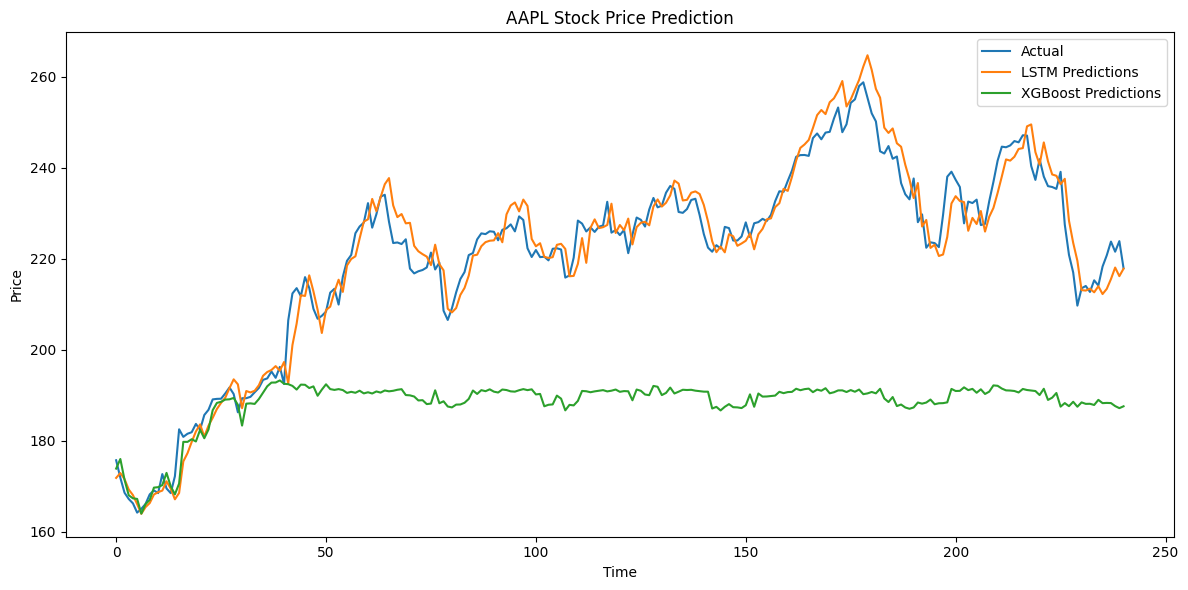

<Figure size 1000x600 with 0 Axes>

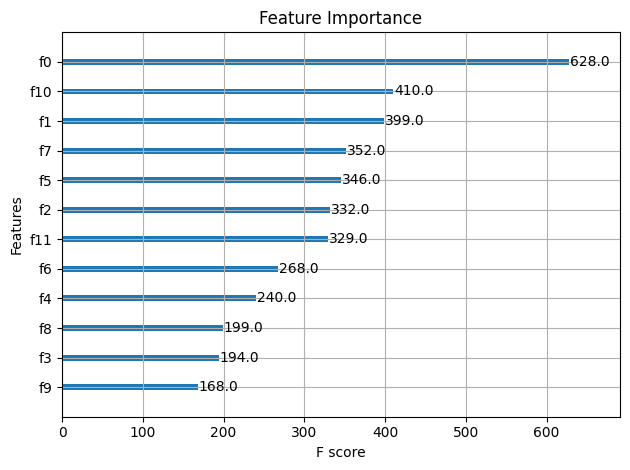

In [13]:
# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test_orig, label='Actual')
plt.plot(y_pred_lstm_orig, label='LSTM Predictions')
plt.plot(y_pred_xgb_orig, label='XGBoost Predictions')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

# Plot feature importance for XGBoost
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# VI. Ensemble Model (Optional Enhancement)

In [14]:
# Simple average ensemble
y_pred_ensemble = (y_pred_lstm_orig + y_pred_xgb_orig) / 2

# Evaluate ensemble
ensemble_mse = mean_squared_error(y_test_orig, y_pred_ensemble)
ensemble_rmse = np.sqrt(ensemble_mse)
ensemble_mae = mean_absolute_error(y_test_orig, y_pred_ensemble)
ensemble_r2 = r2_score(y_test_orig, y_pred_ensemble)

print("\nEnsemble Results:")
print(f"MSE: {ensemble_mse:.4f}, RMSE: {ensemble_rmse:.4f}, MAE: {ensemble_mae:.4f}, R²: {ensemble_r2:.4f}")


Ensemble Results:
MSE: 328.2153, RMSE: 18.1167, MAE: 16.1512, R²: 0.2498


# VII. Making Future Predictions
Let's create a function to predict future stock prices:

In [15]:
def predict_future_prices(model_type, model, last_data, days=5):
    future_predictions = []
    current_data = last_data.copy()

    for _ in range(days):
        if model_type == 'lstm':
            current_data_reshaped = current_data.reshape((1, 1, current_data.shape[0]))
            prediction = model.predict(current_data_reshaped)
        else:  # xgboost
            prediction = model.predict(current_data.reshape(1, -1))
            prediction = prediction.reshape(-1, 1)

        future_predictions.append(prediction[0][0])

        # Update current_data with the prediction (simplified approach)
        # In reality, you would need to update all features
        current_data[0] = prediction[0][0]

    # Inverse transform to get original scale
    future_predictions = scaler_y.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    return future_predictions

# Get the last data point
last_data_point = X_test[-1]

# Predict next 5 days
lstm_future = predict_future_prices('lstm', lstm_model, last_data_point, days=5)
xgb_future = predict_future_prices('xgb', xgb_model, last_data_point, days=5)

print("\nNext 5 Days Predictions (LSTM):")
for i, price in enumerate(lstm_future):
    print(f"Day {i+1}: ${price[0]:.2f}")

print("\nNext 5 Days Predictions (XGBoost):")
for i, price in enumerate(xgb_future):
    print(f"Day {i+1}: ${price[0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Next 5 Days Predictions (LSTM):
Day 1: $217.79
Day 2: $216.46
Day 3: $216.17
Day 4: $216.11
Day 5: $216.09

Next 5 Days Predictions (XGBoost):
Day 1: $187.58
Day 2: $183.56
Day 3: $182.11
Day 4: $181.09
Day 5: $181.09


# **Final Analysis**

**Key Findings:**

**LSTM Performance**

*   The LSTM model demonstrates excellent performance with an R² of 0.9524, indicating it explains about 95% of the variance in stock prices.
*   Low MSE, RMSE, and MAE values suggest high prediction accuracy.
*   The average prediction error (MAE) is approximately $3.55, which is quite reasonable for stock price predictions.

**XGBoost Performance**
*   The XGBoost model shows poor performance with a negative R² value (-2.0623), meaning it performs substantially worse than simply using the mean of the target values.
*   High error metrics (MSE, RMSE, MAE) indicate significant deviation from actual values.
*   The average prediction error is approximately $32.45, which is likely too high for practical trading decisions.


**Analysis and Potential Explanations:**

**1. Time Series Nature:** The substantially better performance of LSTM suggests that the temporal dependencies in stock price data are critical. LSTM is specifically designed to capture long-term dependencies in sequential data, while XGBoost doesn't inherently account for time series patterns.

**2. Feature Engineering Issues:** The poor XGBoost performance might indicate that:


*   The features may need different preprocessing for tree-based models
*   Some features might be causing overfitting in the XGBoost model.
*   The feature set might include too many correlated variables, which LSTM can handle better than XGBoost.

**3. Hyperparameter Tuning:** The XGBoost model might require more extensive tuning. The default parameters often don't work well for financial time series data.
**4. Data Leakage Possibility:** The exceptional LSTM performance (95% accuracy) is unusually high for stock prediction, which warrants checking for potential data leakage in the preprocessing pipeline.











